## Truncated SVD

By: Maddy

# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [184]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

import wordcloud
from tqdm import tqdm_notebook as tqdm
import os
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity
from prettytable import PrettyTable

In [132]:
# using SQLite Table to read data.
con = sqlite3.connect('database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 5000""", con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (5000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [133]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [134]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B007Y59HVM,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ET0,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B007Y59HVM,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ET0,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBE1U,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [135]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B006P7E5ZI,"undertheshrine ""undertheshrine""",1334707200,5,I was recommended to try green tea extract to ...,5


In [136]:
display['COUNT(*)'].sum()

393063

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [137]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [138]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [139]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(4986, 10)

In [140]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

99.72

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [141]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [142]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [143]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(4986, 10)


1    4178
0     808
Name: Score, dtype: int64

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [144]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

Why is this $[...] when the same product is available for $[...] here?<br />http://www.amazon.com/VICTOR-FLY-MAGNET-BAIT-REFILL/dp/B00004RBDY<br /><br />The Victor M380 and M502 traps are unreal, of course -- total fly genocide. Pretty stinky, but only right nearby.
I recently tried this flavor/brand and was surprised at how delicious these chips are.  The best thing was that there were a lot of "brown" chips in the bsg (my favorite), so I bought some more through amazon and shared with family and friends.  I am a little disappointed that there are not, so far, very many brown chips in these bags, but the flavor is still very good.  I like them better than the yogurt and green onion flavor because they do not seem to be as salty, and the onion flavor is better.  If you haven't eaten Kettle chips before, I recommend that you try a bag before buying bulk.  They are thicker and crunchier than Lays but just as fresh out of the bag.
Wow.  So far, two two-star reviews.  One obviously had no 

In [145]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

Why is this $[...] when the same product is available for $[...] here?<br /> /><br />The Victor M380 and M502 traps are unreal, of course -- total fly genocide. Pretty stinky, but only right nearby.


In [146]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

Why is this $[...] when the same product is available for $[...] here? />The Victor M380 and M502 traps are unreal, of course -- total fly genocide. Pretty stinky, but only right nearby.
I recently tried this flavor/brand and was surprised at how delicious these chips are.  The best thing was that there were a lot of "brown" chips in the bsg (my favorite), so I bought some more through amazon and shared with family and friends.  I am a little disappointed that there are not, so far, very many brown chips in these bags, but the flavor is still very good.  I like them better than the yogurt and green onion flavor because they do not seem to be as salty, and the onion flavor is better.  If you haven't eaten Kettle chips before, I recommend that you try a bag before buying bulk.  They are thicker and crunchier than Lays but just as fresh out of the bag.
Wow.  So far, two two-star reviews.  One obviously had no idea what they were ordering; the other wants crispy cookies.  Hey, I'm sorry; b

In [147]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [148]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

Wow.  So far, two two-star reviews.  One obviously had no idea what they were ordering; the other wants crispy cookies.  Hey, I am sorry; but these reviews do nobody any good beyond reminding us to look  before ordering.<br /><br />These are chocolate-oatmeal cookies.  If you do not like that combination, do not order this type of cookie.  I find the combo quite nice, really.  The oatmeal sort of "calms" the rich chocolate flavor and gives the cookie sort of a coconut-type consistency.  Now let is also remember that tastes differ; so, I have given my opinion.<br /><br />Then, these are soft, chewy cookies -- as advertised.  They are not "crispy" cookies, or the blurb would say "crispy," rather than "chewy."  I happen to like raw cookie dough; however, I do not see where these taste like raw cookie dough.  Both are soft, however, so is this the confusion?  And, yes, they stick together.  Soft cookies tend to do that.  They are not individually wrapped, which would add to the cost.  Oh y

In [149]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

Why is this $[...] when the same product is available for $[...] here?<br /> /><br />The Victor  and  traps are unreal, of course -- total fly genocide. Pretty stinky, but only right nearby.


In [150]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

Wow So far two two star reviews One obviously had no idea what they were ordering the other wants crispy cookies Hey I am sorry but these reviews do nobody any good beyond reminding us to look before ordering br br These are chocolate oatmeal cookies If you do not like that combination do not order this type of cookie I find the combo quite nice really The oatmeal sort of calms the rich chocolate flavor and gives the cookie sort of a coconut type consistency Now let is also remember that tastes differ so I have given my opinion br br Then these are soft chewy cookies as advertised They are not crispy cookies or the blurb would say crispy rather than chewy I happen to like raw cookie dough however I do not see where these taste like raw cookie dough Both are soft however so is this the confusion And yes they stick together Soft cookies tend to do that They are not individually wrapped which would add to the cost Oh yeah chocolate chip cookies tend to be somewhat sweet br br So if you wa

In [151]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [152]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|████████████████████████████████████████████████████████████████████████████| 4986/4986 [00:01<00:00, 2498.87it/s]


In [153]:
preprocessed_reviews[1500]

'wow far two two star reviews one obviously no idea ordering wants crispy cookies hey sorry reviews nobody good beyond reminding us look ordering chocolate oatmeal cookies not like combination not order type cookie find combo quite nice really oatmeal sort calms rich chocolate flavor gives cookie sort coconut type consistency let also remember tastes differ given opinion soft chewy cookies advertised not crispy cookies blurb would say crispy rather chewy happen like raw cookie dough however not see taste like raw cookie dough soft however confusion yes stick together soft cookies tend not individually wrapped would add cost oh yeah chocolate chip cookies tend somewhat sweet want something hard crisp suggest nabiso ginger snaps want cookie soft chewy tastes like combination chocolate oatmeal give try place second order'

# [4] Featurization

## [4.1] TF-IDF

In [154]:
tf_idf_vect = TfidfVectorizer(max_features=2500)
tfidf_vect=tf_idf_vect.fit_transform(preprocessed_reviews)
print("some sample features(unique words in the corpus)",tf_idf_vect.get_feature_names()[0:10])
print('='*50)
print("the type of count vectorizer ",type(tfidf_vect))
print("the shape of out text TFIDF vectorizer ",tfidf_vect.get_shape())
print("the number of unique words including both unigrams", tfidf_vect.get_shape()[1])

some sample features(unique words in the corpus) ['ability', 'able', 'absolute', 'absolutely', 'acai', 'acceptable', 'according', 'acid', 'acidic', 'acidity']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (4986, 2500)
the number of unique words including both unigrams 2500


In [155]:
#Printing the shape of data
np.shape(preprocessed_reviews)

(4986,)

## Truncated-SVD

### [5.1] Taking top features from TFIDF,<font color='red'> SET 2</font>

In [156]:
# Please write all the code with proper documentation
indices = np.argsort(tf_idf_vect.idf_)[::-1] #sorting as per idf_
allfeatures = tf_idf_vect.get_feature_names()  #getting feature names
top_n = 2500 #Taking top 2500 features
top_features = [allfeatures[i] for i in indices[:top_n]] #taking top features
print(np.shape(top_features))

(2500,)


In [157]:
print(top_features[:100])

['vernor', 'charger', 'phosphorus', 'electric', 'sojos', 'steaz', 'sassafras', 'cakesters', 'creamers', 'flower', 'coca', 'posts', 'skillet', 'horse', 'coconuts', 'salts', 'mays', 'similac', 'formulas', 'eve', 'fudge', 'gummy', 'acai', 'custard', 'cashews', 'paleo', 'driver', 'asparagus', 'dogfood', 'innova', 'infant', 'dove', 'soap', 'preamp', 'dha', 'grapefruit', 'taffy', 'alive', 'el', 'thyme', 'hines', 'tbsp', 'duncan', 'wafers', 'truffle', 'lactose', 'conventional', 'united', 'skins', 'mae', 'signal', 'pickled', 'bills', 'wedding', 'bone', 'bird', 'bowls', 'watermelon', 'martini', 'mold', 'cento', 'pringles', 'ahmad', 'mueslix', 'carbohydrate', 'pressed', 'backyard', 'reward', 'mixer', 'tapioca', 'rolled', 'jerk', 'additive', 'carton', 'experiment', 'ray', 'thirst', 'vomiting', 'nunaturals', 'nabisco', 'fence', 'cereals', 'twist', 'caviar', 'cider', 'twizzlers', 'chef', 'minus', 'measuring', 'medicinal', 'unsalted', 'setup', 'merrick', 'method', 'mexican', 'mints', 'crushed', 'sho

### [5.2] Calulation of Co-occurrence matrix

In [180]:
# Please write all the code with proper documentation

def co_occurence_matrix(reviews,top_features,neighbour):  
    "This function takes the data corpus , top features and number of neighbous to return a co-occurence matrix."
    data=reviews
    words=top_features
    cooccurrence_matrix = np.zeros((len(words), len(words)))
    review=[]
    dictwords={}
    cntw=-1
    for i in tqdm(words):
        cntw += 1
        dictwords[i]=cntw
    for sentence in tqdm(data):
        reviewlist=sentence.split()
        cnt1=-1
        for i in reviewlist:
            cnt1+=1
            if i in words:
                cnt2=-1
                for j in reviewlist:
                    cnt2+=1
                    if j in words:
                        diff=abs(cnt1-cnt2)
                        if diff<=neighbour:
                            cnti=dictwords[i] 
                            cntj=dictwords[j]
                            cooccurrence_matrix[cnti][cntj] += 1
                
    return cooccurrence_matrix



###### Sample run of cooccurence matrix with test data

In [185]:
test=["abc def ijk pqr", "pqr klm opq", "lmn pqr xyz abc def pqr abc"]
top=["abc","pqr","def"]
neighbour=2 #setting neighbourhood to number 2
#c_matrix=co_occurence_matrix(preprocessed_reviews,top_features,neighbour)
c_matrix_test=co_occurence_matrix(test,top,neighbour)
print(np.shape(c_matrix_test)) #Shape of the co-occurence matrix
print(c_matrix_test)



(3, 3)
[[3. 3. 3.]
 [3. 4. 2.]
 [3. 2. 2.]]


#### Calculating co-occurence matrix for reviews dataset

In [186]:
neighbour=5 #setting neighbourhood to number 5
c_matrix=co_occurence_matrix(preprocessed_reviews,top_features,neighbour) #Calculating cooccurence matrix
print(np.shape(c_matrix)) #Shape of the co-occurence matrix



(2500, 2500)


### [5.3] Finding optimal value for number of components (n) to be retained.

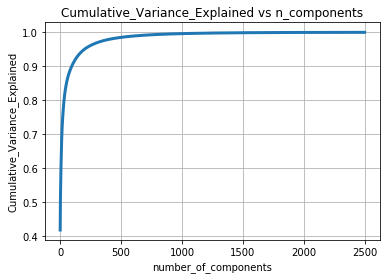

In [187]:
# Please write all the code with proper documentation
svd = TruncatedSVD(n_components=len(top_features)-1)
svd_transform_dataset = svd.fit_transform(c_matrix)
percentage_variance_explained = svd.explained_variance_ / np.sum(svd.explained_variance_)
cum_variance_explained = np.cumsum(percentage_variance_explained)
plt.figure()
plt.clf()
plt.plot(cum_variance_explained, linewidth=3)
plt.grid()
plt.xlabel('number_of_components')
plt.ylabel('Cumulative_Variance_Explained')
plt.title("Cumulative_Variance_Explained vs n_components")
plt.show()

Around 280 components covers 95% of the variance so that would be optimal.

#### Applying Truncated SVD

In [188]:
#Reducing dimensions to 280
truncated_svd = TruncatedSVD(n_components=280)
svd_transform_dataset_final = truncated_svd.fit_transform(c_matrix)

In [189]:
percentage_variance_explained_final = truncated_svd.explained_variance_ / np.sum(truncated_svd.explained_variance_)
cum_variance_explained_truncated_svd = np.cumsum(percentage_variance_explained_final)
print(cum_variance_explained_truncated_svd[-1])

0.9999999999999997


280 components has covered almost all the variance in the dataset.

In [190]:
np.shape(svd_transform_dataset_final) #shape

(2500, 280)

### [5.4] Applying k-means clustering

The inertia for 2 clusters is 71761655.654188
The inertia for 3 clusters is 62409208.364182
The inertia for 4 clusters is 57525827.418391
The inertia for 5 clusters is 56018493.861086
The inertia for 6 clusters is 52390621.884335
The inertia for 7 clusters is 49841860.253382
The inertia for 8 clusters is 47318513.489092
The inertia for 9 clusters is 46055770.174387
The inertia for 10 clusters is 43747504.778890
The inertia for 11 clusters is 41900107.200308
The inertia for 12 clusters is 41430131.141952
The inertia for 13 clusters is 38453340.074463
The inertia for 14 clusters is 37544841.037069
The inertia for 15 clusters is 35281550.307085
The inertia for 16 clusters is 34179702.283312
The inertia for 17 clusters is 33829753.128302
The inertia for 18 clusters is 31674774.978292
The inertia for 19 clusters is 31657522.247478
The inertia for 20 clusters is 30954972.159247
The inertia for 21 clusters is 30129926.290453
The inertia for 22 clusters is 29249951.210989
The inertia for 23 cl

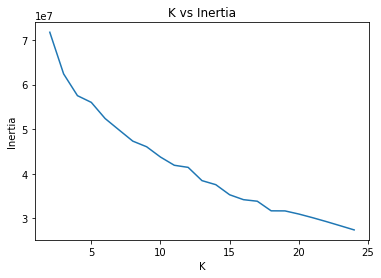

In [191]:
# Please write all the code with proper documentation
# Selecting optimal number of clusters using intertia as a metric
ksvd=[]
inersvd = []
for i in range(2,25):
    kmeans = KMeans(n_clusters=i, random_state=0)
    kmeans.fit(svd_transform_dataset_final)
    ksvd.append(i)
    abiner=kmeans.inertia_
    inersvd.append(abiner)
    print("The inertia for %d clusters is %f"%(i,abiner))

plt.figure()
plt.title("K vs Inertia")
plt.xlabel("K")
plt.ylabel("Inertia")
plt.plot(ksvd,inersvd)
plt.show()

After 11k the intertia is decreasing at less rate so taking 11 as k.

In [201]:
no_of_clusters=11
kmeans = KMeans(n_clusters=no_of_clusters, random_state=0)
kmeans.fit(svd_transform_dataset_final)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=11, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=0, tol=0.0001, verbose=0)

In [202]:
lables = list(set(kmeans.labels_))
clusters = []
for i in lables:
    temp = []
    for j in range(kmeans.labels_.shape[0]):
        if kmeans.labels_[j] == i:
            temp.append(top_features[j])
    clusters.append(temp)

### [5.5] Wordclouds of clusters obtained in the above section

In [203]:
# Please write all the code with proper documentation
def generate_word_cloud(text,number):
    '''This function takes the text and class number to generate the wordcloud for the same.'''
    wc=wordcloud.WordCloud(width=300, height=250,max_font_size=40,background_color="black")
    wc.generate_from_text(text)
    plt.figure( figsize=(20,10) )
    plt.title("class %d cluster" %(number))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.show()

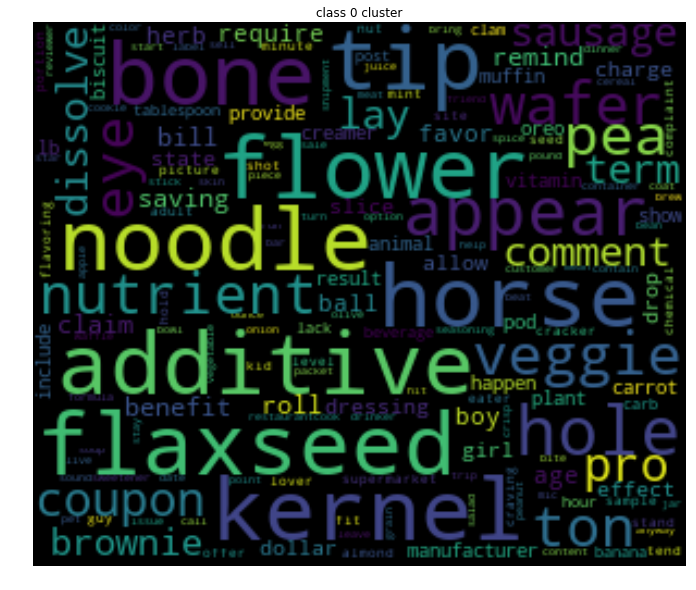

Number of words in cluster 1 is 1
Number of words in cluster 2 is 1
Number of words in cluster 3 is 1
Number of words in cluster 4 is 1
Number of words in cluster 5 is 1
Number of words in cluster 6 is 1
Number of words in cluster 7 is 1
Number of words in cluster 8 is 1
Number of words in cluster 9 is 1


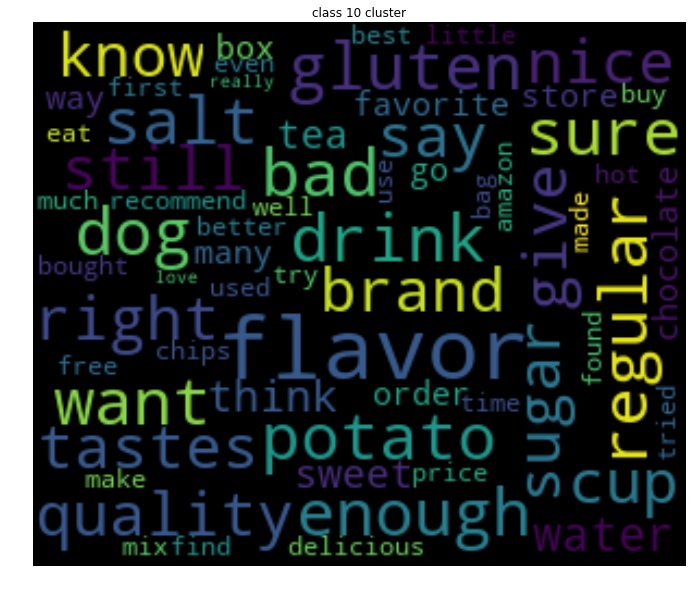

In [204]:
#generating wordcloud for all the classes having number of words more than 1.
for i in lables:
    if len(clusters[i])>1:
        text=" ".join(clusters[i])
        generate_word_cloud(text,i)
    else:
        print("Number of words in cluster %d is %d" %(i,len(clusters[i])))

### [5.6] Function that returns most similar words for a given word.

In [196]:
# Please write all the code with proper documentation
def similar_words(word,svddata,top_features,number):
    ''' Function which returns similar words from the corpus as per the cosine similarity '''
    indexword = top_features.index(word)
    pairwise_distance = cosine_similarity(svddata, svddata[indexword].reshape(1,-1))
    top_indices = np.argsort(pairwise_distance.flatten())[::-1] #sorting the indices
    sorted_pairwise_distance  = np.sort(pairwise_distance.flatten())[::-1] #sorting the distances
    x_table = PrettyTable(["Top_Words","Pairwise Distance"])
    for i in range(number):
        x_table.add_row([top_features[top_indices[i]],sorted_pairwise_distance[i]])
    print("The topmost similar words and their pairwise distance with word -",word)
    print(x_table)

In [208]:
similar_words('food',svd_transform_dataset_final,top_features,10)

The topmost similar words and their pairwise distance with word - food
+-----------+--------------------+
| Top_Words | Pairwise Distance  |
+-----------+--------------------+
|    food   | 1.0000000000000004 |
| allergies | 0.8837200841498977 |
|  merrick  | 0.8527346346384931 |
|    junk   | 0.8516674324721861 |
|  switched | 0.837182067186418  |
|   breed   | 0.7968690982680487 |
|   human   | 0.7870706592539649 |
|    wet    | 0.7697348327393367 |
|    pets   | 0.769318223001092  |
|    pet    | 0.7645494154547114 |
+-----------+--------------------+


In [209]:
similar_words('delicious',svd_transform_dataset_final,top_features,10)

The topmost similar words and their pairwise distance with word - delicious
+-------------+---------------------+
|  Top_Words  |  Pairwise Distance  |
+-------------+---------------------+
|  delicious  |  1.0000000000000004 |
|    sweets   |  0.4702587550765459 |
|    truly    |  0.4617405236664956 |
|    crispy   | 0.45874610681068534 |
|  incredibly | 0.45379698944462754 |
|   besides   | 0.44832291112230194 |
|  refreshing |  0.4333219150468854 |
| wonderfully | 0.42648752226765063 |
|  absolutely |  0.4093135718957638 |
|  strawberry | 0.40570862392753343 |
+-------------+---------------------+


In [210]:
similar_words('hate',svd_transform_dataset_final,top_features,10)

The topmost similar words and their pairwise distance with word - hate
+------------+--------------------+
| Top_Words  | Pairwise Distance  |
+------------+--------------------+
|    hate    | 1.0000000000000004 |
| otherwise  | 0.6587516317845014 |
| personally | 0.6503779451468434 |
|     ok     | 0.6404158668592939 |
|   weird    | 0.6362020447821695 |
|    oily    | 0.6351580087495258 |
|   except   | 0.6260301080878019 |
| expecting  | 0.6259743182125357 |
|     oh     | 0.6216208303584374 |
|    mean    | 0.6198042553845142 |
+------------+--------------------+


In [211]:
similar_words('worst',svd_transform_dataset_final,top_features,10)

The topmost similar words and their pairwise distance with word - worst
+-----------+---------------------+
| Top_Words |  Pairwise Distance  |
+-----------+---------------------+
|   worst   |  1.0000000000000004 |
|    ever   |  0.7539353063470151 |
|   eaten   |  0.5887848325975307 |
|  tasting  |  0.5609649200854222 |
|  greatest |  0.4908528678624149 |
| literally | 0.43764054409247266 |
|   hardly  |  0.4329984386114094 |
|  honestly |  0.4259269864365915 |
|   cases   | 0.40993169616447095 |
|    grey   |  0.4052804628205757 |
+-----------+---------------------+


# [6] Conclusions

In [1]:
# Please write down few lines about what you observed from this assignment. 
# Also please do mention the optimal values that you obtained for number of components & number of clusters.


1. Taking only 2500 top features to be fed into the Trucated SVD model.

2. Computed co-occurence matrix for all the top words in the data. This matrix tells how frequently the words occur with each other. And set the neighbourhood to 5. So anything at 5 places before or after is considered as co-occured.

3. Choose 280 as number of components as it covered more than 99% of the variance.

4. Optimal values of K for clustering is chosen as 11 using elbow method.

6. Created a function to create a worcloud if the number of words in a cluster is more than 1.

7. Used Sklearn's inbuilt library to calculate cosine similarity of the words and to return the similar word via a function.